### Thinking
1. 电商定向广告和搜索广告有怎样的区别，算法模型是否有差别    
  * 搜索广告是精准的，它根据用户搜索查询投放，反映了用户的明确需求；
  * 电商定向广告不针对用户的精准需求，即用户没有明显的意图（主动的Query查询），在进入电商界面之前没有特别明确的目标，需要根据过往历史进行item推荐。
  * 算法模型有区别
  

2. 定向广告都有哪些常见的使用模型，包括Attention机制模型
  * LR MLR DNN DIN DIEN DSIN  
  
  
3. DIN中的Attention机制思想和原理是怎样的  
  * Atten机制指的是将用户diversity（多样性/个性化）和候选广告的匹配，需要通过注意力机制找到关键的商品
  * Attention机制在对用户行为的embedding计算上引入了attention network (也称为Activation Unit) ，把用户历史行为特征进行embedding操作，视为对用户兴趣的表示，之后通过Attention Unit，对每个兴趣表示赋予不同的权值；Attention Weight是由用户历史行为和候选广告进行匹配计算得到的，对应着洞察（用户兴趣的Diversity，以及Local Activation）
  
  
4. DIEN相比于DIN有哪些创新
  * 在于兴趣的推演
  * DIEN使用behavior layer，interest extractor layer 以及 interest evolving layer从用户历史行为中挖掘用户与目标商品相关的兴趣及演变，其中Interest Evolving layer 利用序列模型 AUGRU 的结构将不同时间的用户兴趣串联起来，形成兴趣进化的链条


5. DSIN关于Session的洞察是怎样的，如何对Session兴趣进行表达
  * DSIN通过浏览器的方式做session会话的切割，利用用户的行为序列中的多个历史会话，一个session是在给定的时间范围内发生的交互列表（用户行为列表）
  * 洞察：Sequence视角，同样可以看到user interest的变化；Session视角，每个Session中的行为是相近的，而在不同会话之间差别是很大的（类似聚类）；Session的划分和airbnb一样，即将用户的点击行为按照时间排序，前后的时间间隔大于30min，算成另一个session
  * 如何对Session兴趣进行表达：将用户的连续行为自然地划分为Session，通过带有偏置编码的self attention网络对每个会话进行建模；使用BI-LSTM捕捉用户不同历史会话兴趣的交互和演变；设计了两个Activation Unit，将它们与目标item聚合起来，形成行为序列的最终表示形式

  
6. 如果你来设计淘宝定向广告，会有哪些future work（即下一个阶段的idea）
  * 通过用户聚类，参考同一个cluster中其他用户购买过的商品，进行推荐

### Action
数据集：天猫用户复购预测  
Score > 0.66

###  使用机器学习模型XGBoost

In [1]:
import gc
import pandas as pd

In [2]:
# 加载小样本
# user_log = pd.read_csv('./data_format1_small/sample_user_log.csv', dtype={'time_stamp':'str'})
# user_info = pd.read_csv('./data_format1_small/sample_user_info.csv')
# train_data1 = pd.read_csv('./data_format1_small/train.csv')
# submission = pd.read_csv('./data_format1_small/test.csv')

## 加载全量样本
user_log = pd.read_csv('./data_format1/user_log_format1.csv', dtype={'time_stamp':'str'})
user_info = pd.read_csv('./data_format1/user_info_format1.csv')
train_data1 = pd.read_csv('./data_format1/train_format1.csv')
submission = pd.read_csv('./data_format1/test_format1.csv')

train_data = pd.read_csv('./data_format2/train_format2.csv')
train_data1['origin'] = 'train'
submission['origin'] = 'test'


In [3]:
matrix = pd.concat([train_data1, submission], ignore_index=True, sort=False)
print(matrix)

        user_id  merchant_id  label origin  prob
0         34176         3906    0.0  train   NaN
1         34176          121    0.0  train   NaN
2         34176         4356    1.0  train   NaN
3         34176         2217    0.0  train   NaN
4        230784         4818    0.0  train   NaN
...         ...          ...    ...    ...   ...
522336   228479         3111    NaN   test   NaN
522337    97919         2341    NaN   test   NaN
522338    97919         3971    NaN   test   NaN
522339    32639         3536    NaN   test   NaN
522340    32639         3319    NaN   test   NaN

[522341 rows x 5 columns]


In [4]:
matrix.drop(['prob'], axis=1, inplace=True)


In [5]:
# 连接user_info表，通过user_id关联
matrix = matrix.merge(user_info, on='user_id', how='left')

In [6]:
# 使用merchant_id（原列名seller_id）
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)

In [7]:
# 格式化
user_log['user_id'] = user_log['user_id'].astype('int32')
user_log['merchant_id'] = user_log['merchant_id'].astype('int32')
user_log['item_id'] = user_log['item_id'].astype('int32')
user_log['cat_id'] = user_log['cat_id'].astype('int32')
user_log['brand_id'].fillna(0, inplace=True)
user_log['brand_id'] = user_log['brand_id'].astype('int32')
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%H%M')

In [8]:
matrix['age_range'].fillna(0, inplace=True)
# 0:female, 1:male, 2:unknown
matrix['gender'].fillna(2, inplace=True)
matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'] = matrix['gender'].astype('int8')
matrix['label'] = matrix['label'].astype('str')
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['merchant_id'] = matrix['merchant_id'].astype('int32')
del user_info, train_data1
gc.collect()
print(matrix)

        user_id  merchant_id label origin  age_range  gender
0         34176         3906   0.0  train          6       0
1         34176          121   0.0  train          6       0
2         34176         4356   1.0  train          6       0
3         34176         2217   0.0  train          6       0
4        230784         4818   0.0  train          0       0
...         ...          ...   ...    ...        ...     ...
522336   228479         3111   nan   test          6       0
522337    97919         2341   nan   test          8       1
522338    97919         3971   nan   test          8       1
522339    32639         3536   nan   test          0       0
522340    32639         3319   nan   test          0       0

[522341 rows x 6 columns]


In [9]:
# User特征处理
groups = user_log.groupby(['user_id'])

In [10]:
# 用户交互行为数量 u1
temp = groups.size().reset_index().rename(columns={0:'u1'})
matrix = matrix.merge(temp, on='user_id', how='left')

In [11]:
# 对于每个user_id 不重复的item_id的数量 => u2
temp = groups['item_id'].agg([('u2', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
# 对于每个user_id 不重复的cat_id的数量 => u3
temp = groups['cat_id'].agg([('u3', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['merchant_id'].agg([('u4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['brand_id'].agg([('u5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')

In [12]:
# 时间间隔特征 u6 按照小时
# 对于每个user_id 计算time_stamp的最小时间 => F_time, 最大时间max => L_time
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.seconds/3600
matrix = matrix.merge(temp[['user_id', 'u6']], on='user_id', how='left')
# 统计操作类型为0，1，2，3的个数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'u7', 1:'u8', 2:'u9', 3:'u10'})
matrix = matrix.merge(temp, on='user_id', how='left')
print(matrix)

        user_id  merchant_id label origin  age_range  gender    u1    u2  u3  \
0         34176         3906   0.0  train          6       0   451   256  45   
1         34176          121   0.0  train          6       0   451   256  45   
2         34176         4356   1.0  train          6       0   451   256  45   
3         34176         2217   0.0  train          6       0   451   256  45   
4        230784         4818   0.0  train          0       0    54    31  17   
...         ...          ...   ...    ...        ...     ...   ...   ...  ..   
522336   228479         3111   nan   test          6       0  2004  1173  71   
522337    97919         2341   nan   test          8       1    55    29  14   
522338    97919         3971   nan   test          8       1    55    29  14   
522339    32639         3536   nan   test          0       0    72    46  24   
522340    32639         3319   nan   test          0       0    72    46  24   

         u4   u5        u6      u7   u8

In [13]:
# 商家特征处理
groups = user_log.groupby(['merchant_id'])
# 商家被交互行为数量 m1
temp = groups.size().reset_index().rename(columns={0:'m1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值
temp = groups['user_id', 'item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'user_id':'m2', 'item_id':'m3', 'cat_id':'m4', 'brand_id':'m5'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的action_type 唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'m6', 1:'m7', 2:'m8', 3:'m9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 按照merchant_id 统计随机负采样的个数
temp = train_data[train_data['label']==-1].groupby(['merchant_id']).size().reset_index().rename(columns={0:'m10'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
print(matrix)

<ipython-input-13-0bbc14a3a415>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = groups['user_id', 'item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'user_id':'m2', 'item_id':'m3', 'cat_id':'m4', 'brand_id':'m5'})


        user_id  merchant_id label origin  age_range  gender    u1    u2  u3  \
0         34176         3906   0.0  train          6       0   451   256  45   
1         34176          121   0.0  train          6       0   451   256  45   
2         34176         4356   1.0  train          6       0   451   256  45   
3         34176         2217   0.0  train          6       0   451   256  45   
4        230784         4818   0.0  train          0       0    54    31  17   
...         ...          ...   ...    ...        ...     ...   ...   ...  ..   
522336   228479         3111   nan   test          6       0  2004  1173  71   
522337    97919         2341   nan   test          8       1    55    29  14   
522338    97919         3971   nan   test          8       1    55    29  14   
522339    32639         3536   nan   test          0       0    72    46  24   
522340    32639         3319   nan   test          0       0    72    46  24   

         u4  ...     m1     m2    m3   

In [14]:
# 按照user_id, merchant_id分组
groups = user_log.groupby(['user_id', 'merchant_id'])
temp = groups.size().reset_index().rename(columns={0:'um1'}) #统计行为个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'um2', 'cat_id':'um3', 'brand_id':'um4'}) #统计item_id, cat_id, brand_id唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'um5', 1:'um6', 2:'um7', 3:'um8'})#统计不同action_type唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['time_stamp'].agg([('first', 'min'), ('last', 'max')]).reset_index()
temp['um9'] = (temp['last'] - temp['first']).dt.seconds/3600
temp.drop(['first', 'last'], axis=1, inplace=True)
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left') #统计时间间隔
print(matrix)

<ipython-input-14-10b202c0bf01>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'um2', 'cat_id':'um3', 'brand_id':'um4'}) #统计item_id, cat_id, brand_id唯一个数


        user_id  merchant_id label origin  age_range  gender    u1    u2  u3  \
0         34176         3906   0.0  train          6       0   451   256  45   
1         34176          121   0.0  train          6       0   451   256  45   
2         34176         4356   1.0  train          6       0   451   256  45   
3         34176         2217   0.0  train          6       0   451   256  45   
4        230784         4818   0.0  train          0       0    54    31  17   
...         ...          ...   ...    ...        ...     ...   ...   ...  ..   
522336   228479         3111   nan   test          6       0  2004  1173  71   
522337    97919         2341   nan   test          8       1    55    29  14   
522338    97919         3971   nan   test          8       1    55    29  14   
522339    32639         3536   nan   test          0       0    72    46  24   
522340    32639         3319   nan   test          0       0    72    46  24   

         u4  ...   m10  um1  um2  um3  

In [15]:
#用户购买点击比
matrix['r1'] = matrix['u9']/matrix['u7'] 
#商家购买点击比
matrix['r2'] = matrix['m8']/matrix['m6'] 
#不同用户不同商家购买点击比
matrix['r3'] = matrix['um7']/matrix['um5']
matrix.fillna(0, inplace=True)

In [16]:
# # 修改age_range字段名称为 age_0, age_1, age_2... age_8
temp = pd.get_dummies(matrix['age_range'], prefix='age')
matrix = pd.concat([matrix, temp], axis=1)
temp = pd.get_dummies(matrix['gender'], prefix='g')
matrix = pd.concat([matrix, temp], axis=1)
matrix.drop(['age_range', 'gender'], axis=1, inplace=True)
print(matrix)

        user_id  merchant_id label origin    u1    u2  u3   u4   u5        u6  \
0         34176         3906   0.0  train   451   256  45  109  108  5.833333   
1         34176          121   0.0  train   451   256  45  109  108  5.833333   
2         34176         4356   1.0  train   451   256  45  109  108  5.833333   
3         34176         2217   0.0  train   451   256  45  109  108  5.833333   
4        230784         4818   0.0  train    54    31  17   20   19  5.166667   
...         ...          ...   ...    ...   ...   ...  ..  ...  ...       ...   
522336   228479         3111   nan   test  2004  1173  71  278  282  6.000000   
522337    97919         2341   nan   test    55    29  14   17   17  4.750000   
522338    97919         3971   nan   test    55    29  14   17   17  4.750000   
522339    32639         3536   nan   test    72    46  24   33   35  5.800000   
522340    32639         3319   nan   test    72    46  24   33   35  5.800000   

        ...  age_2  age_3  

In [17]:
# 分割训练数据和测试数据
train_data = matrix[matrix['origin'] == 'train'].drop(['origin'], axis=1)
test_data = matrix[matrix['origin'] == 'test'].drop(['label', 'origin'], axis=1)
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']
del temp, matrix
gc.collect()

84

In [18]:
# 使用机器学习工具
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
import xgboost as xgb


In [19]:
# 将训练集进行切分，20%用于验证
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=.2)

In [20]:
# 使用XGBoost
model = xgb.XGBClassifier(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42    
)

In [21]:
model.fit(
    X_train, y_train,
    eval_metric='auc', eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=True,
    #早停法，如果auc在10epoch没有进步就stop
    early_stopping_rounds=10 
)

[0]	validation_0-auc:0.62849	validation_1-auc:0.62782
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.64811	validation_1-auc:0.64210
[2]	validation_0-auc:0.65415	validation_1-auc:0.64820
[3]	validation_0-auc:0.65828	validation_1-auc:0.64986
[4]	validation_0-auc:0.65969	validation_1-auc:0.65257
[5]	validation_0-auc:0.66278	validation_1-auc:0.65538
[6]	validation_0-auc:0.66459	validation_1-auc:0.65361
[7]	validation_0-auc:0.66524	validation_1-auc:0.65488
[8]	validation_0-auc:0.66687	validation_1-auc:0.65558
[9]	validation_0-auc:0.66841	validation_1-auc:0.65775
[10]	validation_0-auc:0.66995	validation_1-auc:0.65773
[11]	validation_0-auc:0.67174	validation_1-auc:0.65840
[12]	validation_0-auc:0.67326	validation_1-auc:0.65860
[13]	validation_0-auc:0.67426	validation_1-auc:0.65777
[14]	validation_0-auc:0.67575	validation_1-auc:0.65851
[15]	validation_0-auc:0.6777

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=300, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [22]:

model.fit(X_train, y_train)

prob = model.predict_proba(test_data)
submission['prob'] = pd.Series(prob[:,1])
submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('prediction.csv', index=False)

score = 0.6769
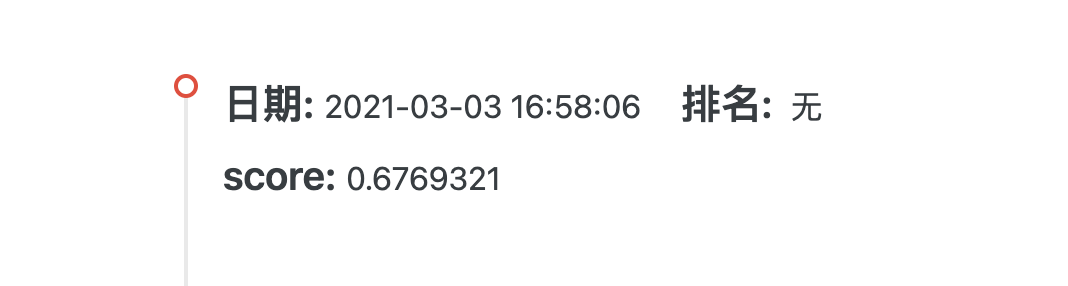